In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import label

# Cleaning the dataset

In [2]:
df= pd.read_csv('CTD_curated_genes_diseases.csv')

print(df.head())
#print(df.describe())
print(len(df))
print(df.shape)


  GeneSymbol  GeneID                DiseaseName     DiseaseID  \
0          A   50518                 Dermatitis  MESH:D003872   
1          A   50518          Diabetes Mellitus  MESH:D003920   
2          A   50518  Diabetes Mellitus, Type 2  MESH:D003924   
3          A   50518     Diabetic Nephropathies  MESH:D003928   
4          A   50518                      Edema  MESH:D004487   

     DirectEvidence OmimIDs PubMedIDs  
0  marker/mechanism     NaN  32937126  
1  marker/mechanism     NaN   1473152  
2  marker/mechanism     NaN   8146154  
3  marker/mechanism     NaN  37769864  
4  marker/mechanism     NaN  32937126  
34156
(34156, 7)


In [3]:
new_dataset = df.dropna(subset=['GeneSymbol','GeneID','DiseaseName','DiseaseID']) # remove all rows that have any missing values
new_dataset = new_dataset.drop(columns=['OmimIDs','PubMedIDs'])
new_dataset.drop_duplicates()
print(new_dataset.head())
print(len(new_dataset))
print(new_dataset.shape)

new_dataset.isnull().sum()

  GeneSymbol  GeneID                DiseaseName     DiseaseID  \
0          A   50518                 Dermatitis  MESH:D003872   
1          A   50518          Diabetes Mellitus  MESH:D003920   
2          A   50518  Diabetes Mellitus, Type 2  MESH:D003924   
3          A   50518     Diabetic Nephropathies  MESH:D003928   
4          A   50518                      Edema  MESH:D004487   

     DirectEvidence  
0  marker/mechanism  
1  marker/mechanism  
2  marker/mechanism  
3  marker/mechanism  
4  marker/mechanism  
34156
(34156, 5)


GeneSymbol        0
GeneID            0
DiseaseName       0
DiseaseID         0
DirectEvidence    0
dtype: int64

# Creating the graph

In [ ]:
from node2vec import Node2Vec
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import networkx as nx
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch

def encode_evidence(evidence):
    if pd.notna(evidence):
        return encoder.transform([[evidence]])[0]
    else:
        return [0] * len(evidence_list)

def build_graph_with_node2vec(data, embedding_dim=64):
    # Build your graph G as before, WITHOUT adding x features yet
    G = nx.DiGraph()

    genes = data[['GeneID', 'GeneSymbol']].drop_duplicates()
    G.add_nodes_from(
        (row.GeneID, {'type': 'gene', 'label': row.GeneSymbol})
        for row in genes.itertuples(index=False)
    )

    diseases = data[['DiseaseID', 'DiseaseName']].drop_duplicates()
    G.add_nodes_from(
        (row.DiseaseID, {'type': 'disease', 'label': row.DiseaseName})
        for row in diseases.itertuples(index=False)
    )

    # Encode evidence as you already do and add edges
    evidence_list = data['DirectEvidence'].dropna().unique()
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(evidence_list.reshape(-1, 1))

    data['EncodedEvidence'] = data['DirectEvidence'].apply(lambda x: encode_evidence(x, encoder, evidence_list))

    edges = [
        (row.GeneID, row.DiseaseID, {'evidence': torch.tensor(row.EncodedEvidence, dtype=torch.float)})
        for row in data.itertuples(index=False)
    ]
    G.add_edges_from(edges)

    # Now run node2vec on G (use undirected for embedding quality)
    node2vec = Node2Vec(G.to_undirected(), dimensions=embedding_dim, walk_length=30, num_walks=200, workers=4)

    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Assign embeddings as node features x
    for node in G.nodes():
        embedding = model.wv[str(node)]  # node2vec keys are strings
        G.nodes[node]['x'] = torch.tensor(embedding, dtype=torch.float)

    return G


# Testing with a mini subgraph

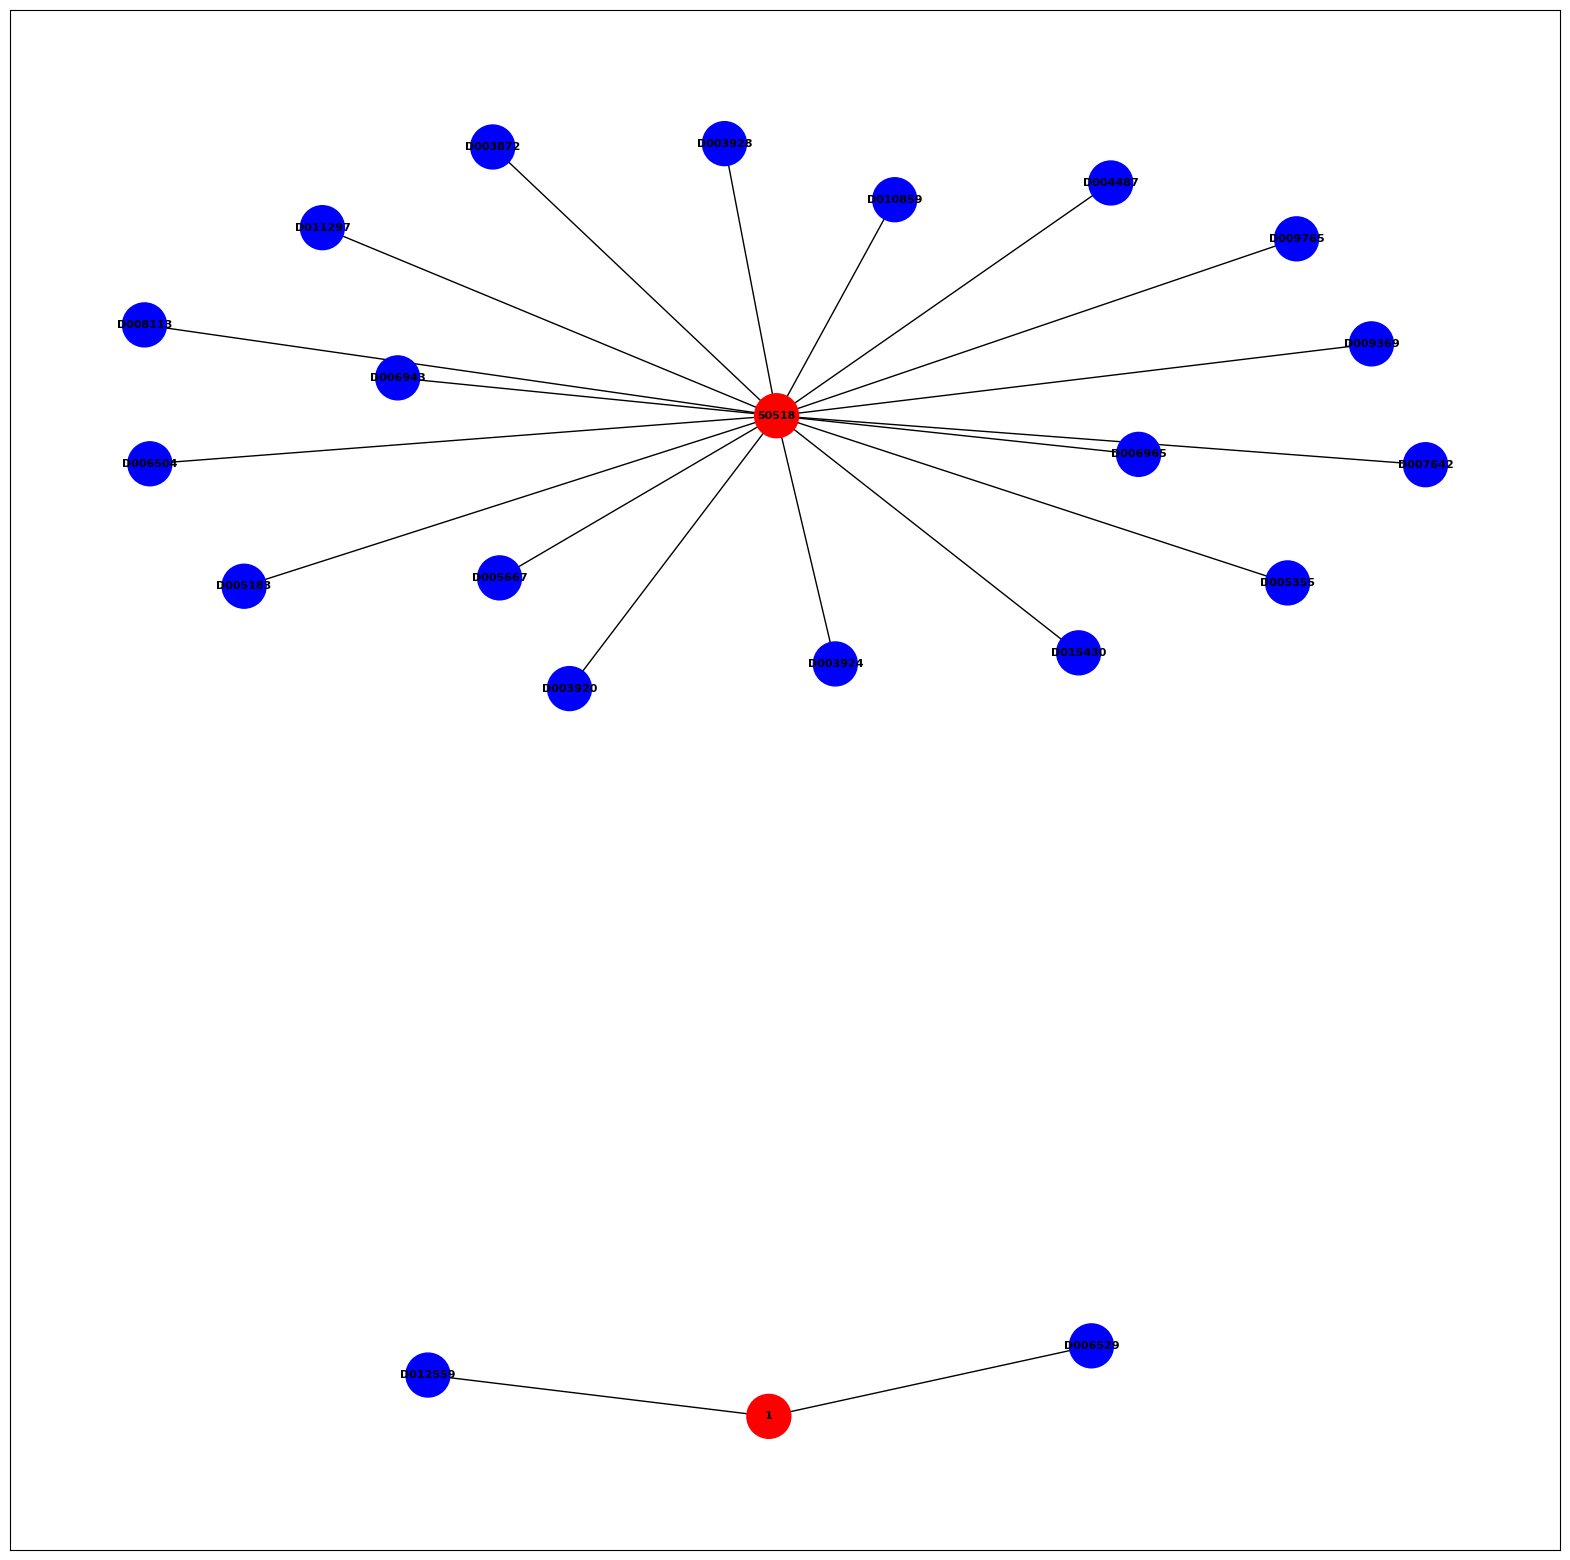

My subgraph:  Graph with 22 nodes and 20 edges


In [5]:
sub_edge = list(G.edges())[:20]
H = G.edge_subgraph(sub_edge).copy()

labels_H = {
    node: str(node).replace("MESH:","").replace("OMIM:","")
    for node in H.nodes
}
pos_H = nx.spring_layout(H,seed=2, k=0.5) # bigger k than more space between nodes
colors_H = ["red" if H.nodes[n]["type"] == "gene" else "blue" for n in H.nodes]
plt.figure(figsize=(20,20))
nx.draw_networkx(H,pos= pos_H,labels= labels_H, node_color=colors_H, with_labels=True, edge_color='black', node_size=1000, font_size=8, font_color='black', font_weight='bold')
plt.show()

print("My subgraph: ",H)

# Degree Centrality

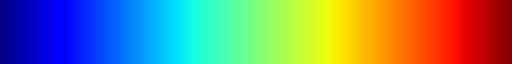

In [6]:
plt.cm.jet

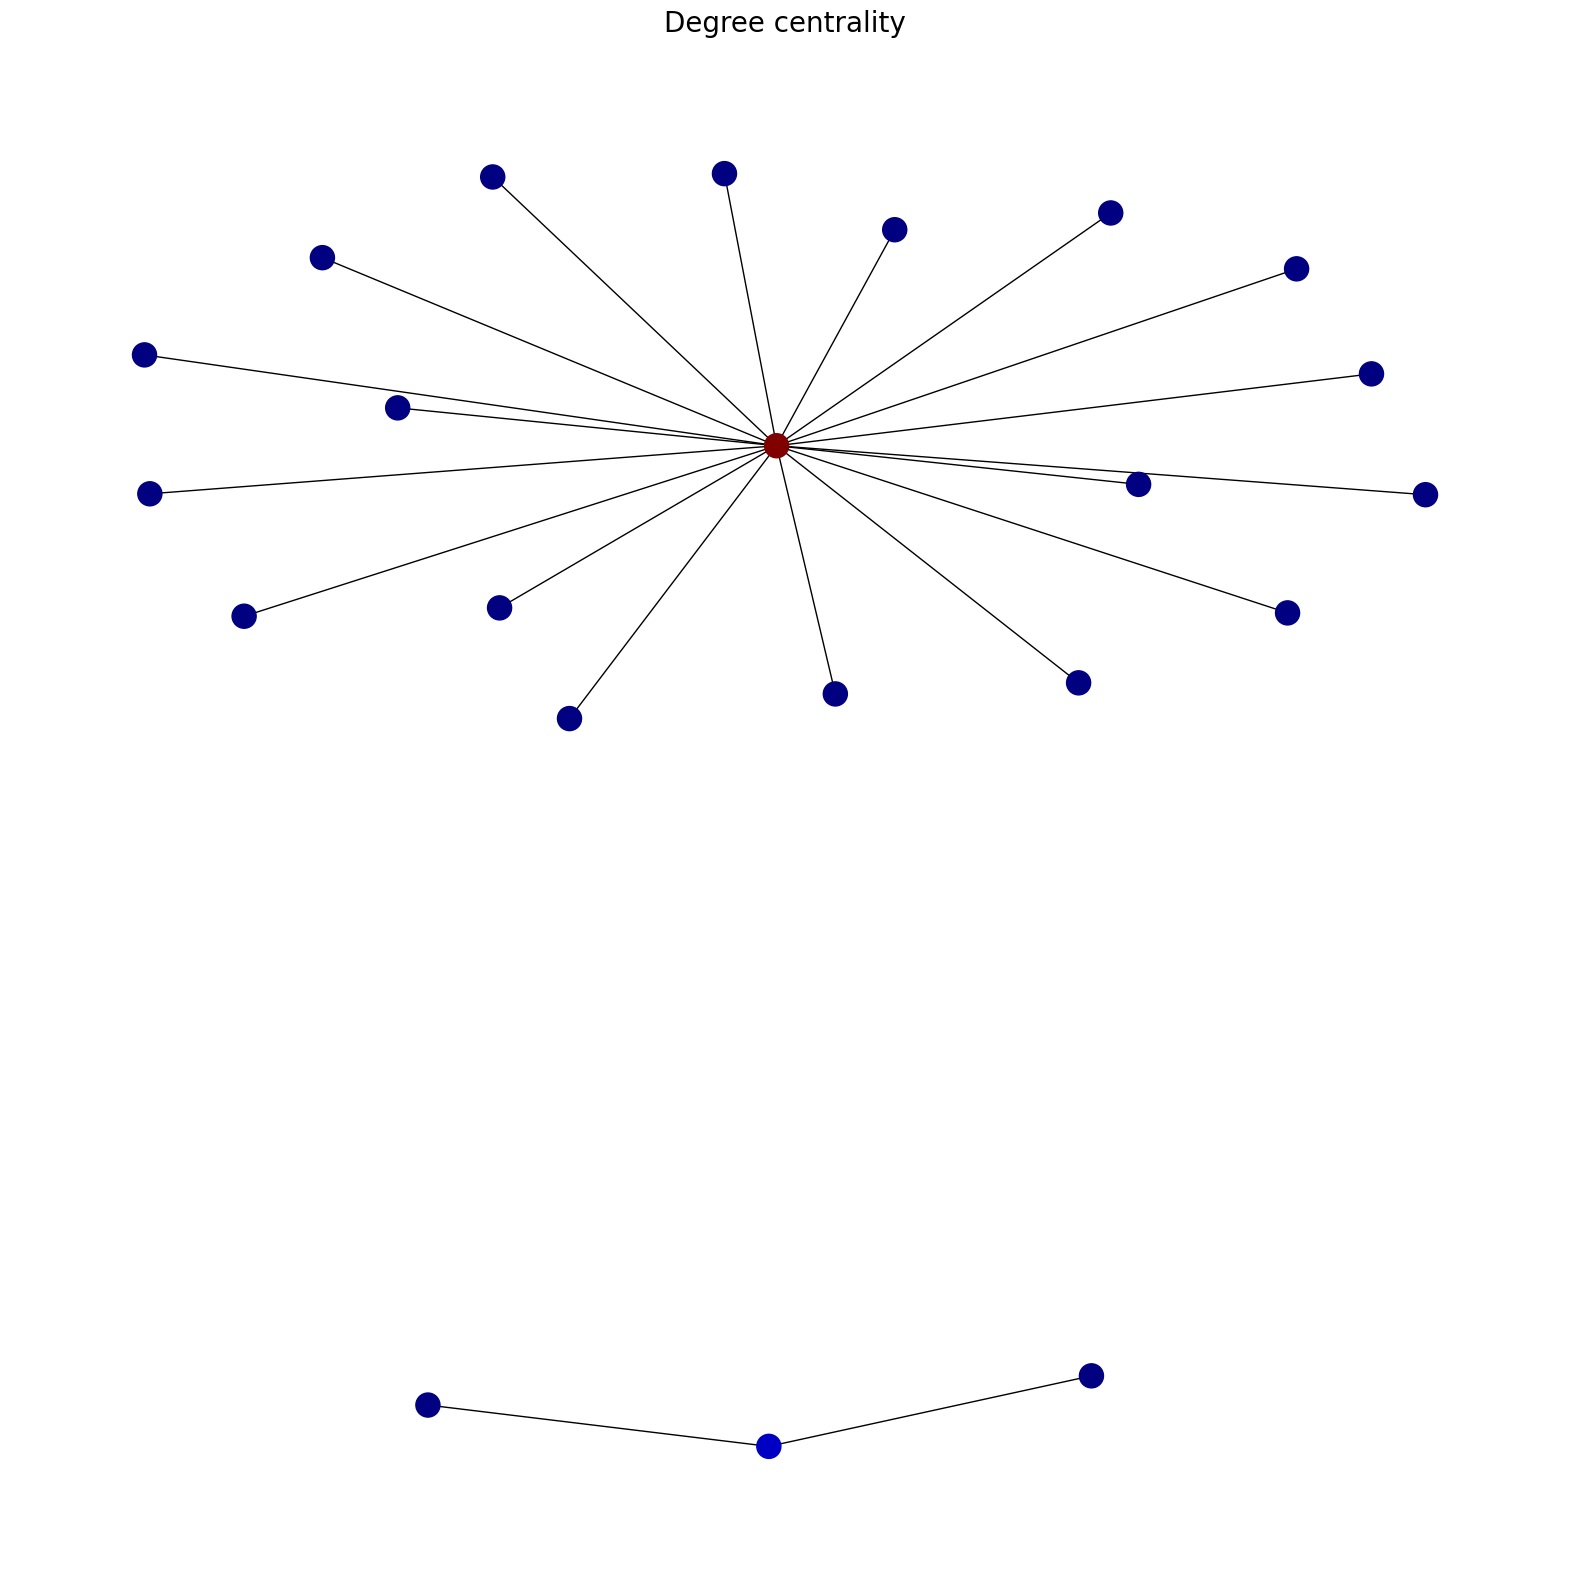

In [7]:
deg_colors = list(H.degree(n) for n in H.nodes)

plt.figure(figsize=(20,20))
plt.title("Degree centrality", size=20)
nx.draw(H, pos=pos_H, node_color=deg_colors, cmap=plt.cm.jet)

# Betweeness

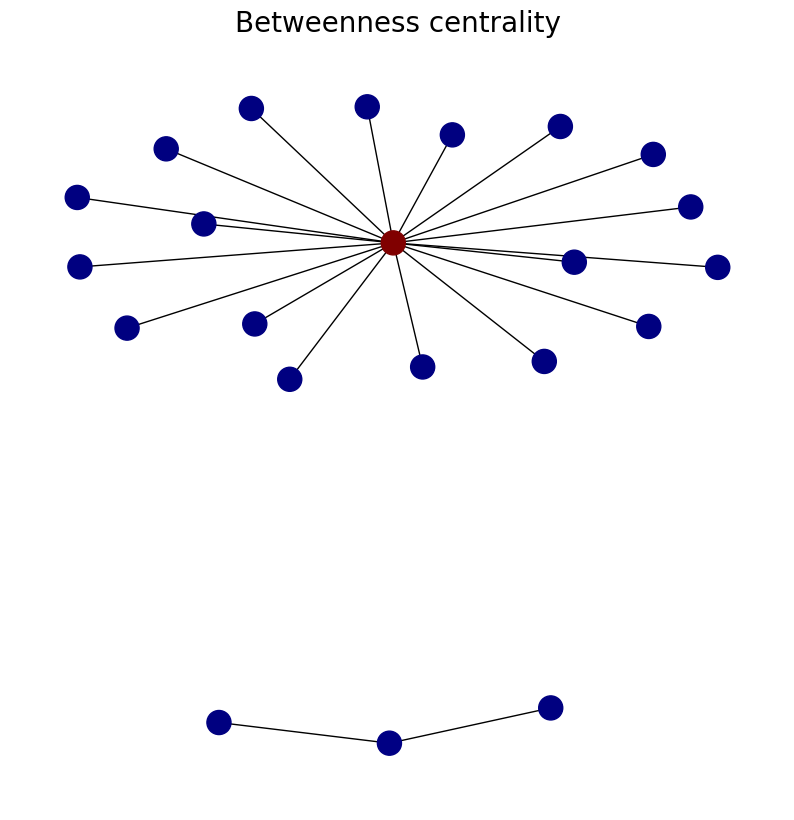

In [8]:
btw_colors = list(nx.betweenness_centrality(H).values())

plt.figure(figsize=(10, 10))
plt.title("Betweenness centrality", size=20)
nx.draw(H, pos=pos_H, node_color=btw_colors, cmap=plt.cm.jet)

# Closeness

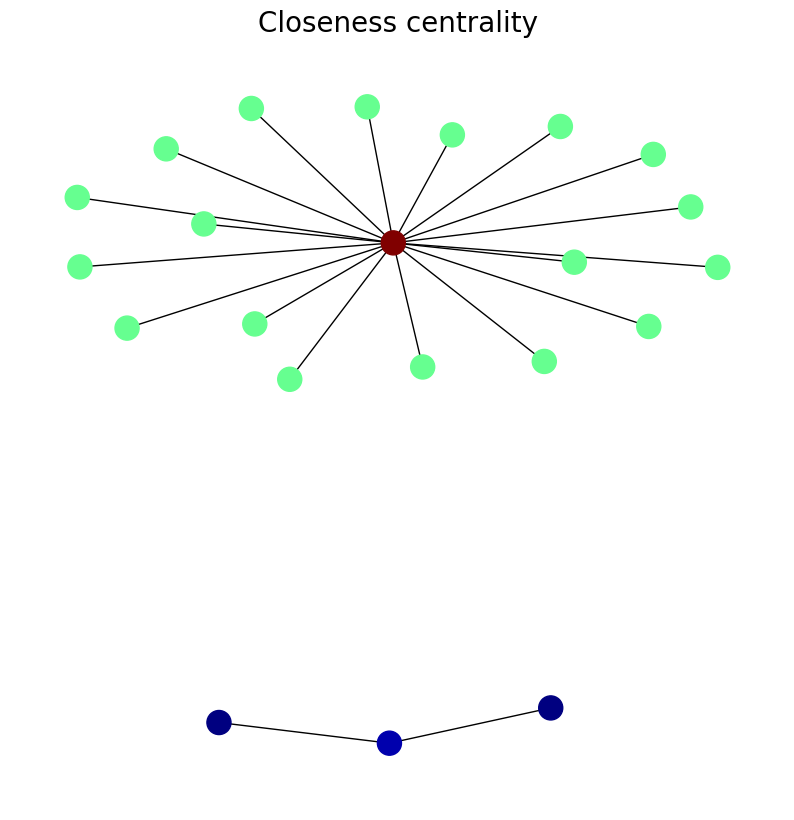

In [9]:
btw_colors = list(nx.closeness_centrality(H).values())

plt.figure(figsize=(10, 10))
plt.title("Closeness centrality", size=20)
nx.draw(H, pos=pos_H, node_color=btw_colors, cmap=plt.cm.jet)

# Communities: Modularity

In [10]:
from typing import List, Set

from networkx.algorithms.community.quality import (
    is_partition,
    modularity,
)

def my_modularity(G: nx.Graph, communities: List[Set]) -> float:
    """
    Calculate modularity given a graph G and a list of communities
    """
    assert is_partition(G, communities), "communities must be a partition of G's nodes"
    m = G.number_of_edges()
    Q = 0
    for community in communities:
        s = nx.subgraph(G, community)  # group s
        ms = s.number_of_edges()
        ks = sum(G.degree(u) for u in s.nodes)
        Q += ms / m - (ks / (2 * m)) ** 2
    return Q

## Graph Partitioning

In [11]:
def communities_to_dict(com: list):
    """Transforms a communities list formed from a list of sets
    [{u1, u2, ...}, {v1, v2, ...}, ...] into a {node:community} dict
    """
    d = {}
    for v in range(len(com)):
        for k in com[v]:
            d[k] = v
    return d

### Girvan Newman

In [12]:
import itertools
from networkx.algorithms.community import girvan_newman

## This is from the `girvan_newman` docs
k = 12  # take at most k elements for each community
comp = girvan_newman(H)
# Take the last partition with <= k communities
limited = itertools.takewhile(lambda c: len(c) <= k, comp)

for communities in limited:
    communities = list(sorted(str(c)) for c in communities)

d = communities_to_dict(communities)


node_color = list(d.values())  # Community color
#plt.title(f"Partitioned\n{len(communities) = }\n{modularity(H, communities) = :.2f}")


# GNN

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_networkx
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics import accuracy_score
import copy

In [21]:
def merge_edge_labels(data):
    edge_label_index = torch.cat([data.pos_edge_label_index, data.neg_edge_label_index], dim=1)
    edge_label = torch.cat([data.pos_edge_label, data.neg_edge_label], dim=0)
    data.edge_label_index = edge_label_index
    data.edge_label = edge_label
    return data

In [23]:
class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.3, negative_slope=0.2, dot_product=True):
        super(LinkPredModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout
        self.negative_slope = negative_slope
        self.dot_product = dot_product
        if not dot_product:
            self.classifier = torch.nn.Linear(2 * hidden_dim, 1)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, x, edge_index, edge_label_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x, negative_slope=self.negative_slope)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        x_src = x[edge_label_index[0]]
        x_trg = x[edge_label_index[1]]

        if self.dot_product:
            return torch.sum(x_src * x_trg, dim=1)
        else:
            x_cat = torch.cat([x_src, x_trg], dim=1)
            return self.classifier(x_cat).squeeze()

    def loss(self, preds, link_label):
        return self.loss_fn(preds, link_label.type(preds.dtype))


In [30]:
original_nodes = list(G.nodes(data=True))
node_id_map = {}
for idx, (node_id, attrs) in enumerate(original_nodes):
    if attrs.get("type") == "gene":
        node_id_map[idx] = attrs.get("geneSymbol", node_id)
    elif attrs.get("type") == "disease":
        node_id_map[idx] = attrs.get("name", node_id)
    else:
        node_id_map[idx] = node_id

data_G = from_networkx(G, group_node_attrs=['x'], group_edge_attrs=['evidence'])
data = data_G.clone()

transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    split_labels=True
)
train_data, val_data, test_data = transform(data)

train_data = merge_edge_labels(train_data)
val_data = merge_edge_labels(val_data)
test_data = merge_edge_labels(test_data)

In [25]:
def train(model, data_train, data_val, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index, data_train.edge_label_index)
    loss = model.loss(out, data_train.edge_label)
    loss.backward()
    optimizer.step()

    loss_train, acc_train = test(model, data_train)
    loss_val, acc_val = test(model, data_val)
    return loss_train, acc_train, loss_val, acc_val

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_label_index)
    loss = model.loss(out, data.edge_label.type(out.dtype))
    preds = (torch.sigmoid(out) > 0.5).float()
    acc = (preds == data.edge_label).sum().item() / data.edge_label.size(0)
    return loss.item(), acc


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinkPredModel(data.num_node_features, 128, dot_product=True).to(device)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


In [32]:
best_model, best_loss = None, float('inf')
for epoch in range(51):
    loss_train, acc_train, loss_val, acc_val = train(model, train_data, val_data, optimizer)
    if loss_val < best_loss:
        best_loss = loss_val
        best_model = copy.deepcopy(model)
    if epoch % 10 == 0:
        print(f"{epoch=}	{loss_train=:.4f}	{acc_train=:.4f}	{loss_val=:.4f}	{acc_val=:.4f}")


epoch=0	loss_train=34352.4180	acc_train=0.6178	loss_val=33837.6367	acc_val=0.5644
epoch=10	loss_train=6259.1846	acc_train=0.5007	loss_val=6283.1782	acc_val=0.5025
epoch=20	loss_train=2939.2217	acc_train=0.5774	loss_val=3057.9138	acc_val=0.5526
epoch=30	loss_train=1066.4956	acc_train=0.6115	loss_val=1076.5911	acc_val=0.5530
epoch=40	loss_train=419.2265	acc_train=0.5998	loss_val=501.8882	acc_val=0.5217
epoch=50	loss_train=209.9319	acc_train=0.6339	loss_val=287.1931	acc_val=0.5622


In [37]:
@torch.no_grad()
def predict_new_edges(model, data, node_id_map, threshold=0.9, original_edge_index=None, node_attrs=None):
    """
    node_attrs: list or dict mapping node index -> dict of attributes (including 'type')
    """
    model.eval()
    out = model(data.x, data.edge_index, data.edge_label_index)
    probs = torch.sigmoid(out)

    mask = probs > threshold
    predicted_edges = data.edge_label_index[:, mask].T
    predicted_scores = probs[mask]

    existing_edges = set()
    if original_edge_index is not None:
        for i in range(original_edge_index.size(1)):
            u, v = original_edge_index[:, i].tolist()
            existing_edges.add(frozenset((u, v)))

    new_links = []
    for i in range(predicted_edges.size(0)):
        src, tgt = predicted_edges[i].tolist()

        # Skip if edge already exists
        if frozenset((src, tgt)) in existing_edges:
            continue

        # Filter edges so one node is gene, other is disease
        src_type = node_attrs[src].get('type')
        tgt_type = node_attrs[tgt].get('type')

        if (src_type == 'gene' and tgt_type == 'disease') or (src_type == 'disease' and tgt_type == 'gene'):
            new_links.append({
                "source": node_id_map.get(src, f"id:{src}"),
                "target": node_id_map.get(tgt, f"id:{tgt}"),
                "score": round(predicted_scores[i].item(), 4)
            })

    return new_links


In [38]:
node_attrs = []
for node_id, attrs in original_nodes:
    node_attrs.append(attrs)

new_edges = predict_new_edges(
    best_model,
    test_data,
    node_id_map,
    threshold=0.9,
    original_edge_index=data.edge_index,
    node_attrs=node_attrs
)

print("\nNew Predicted Gene-Disease Links:")
for edge in new_edges:
    print(edge)



🧬 New Predicted Gene-Disease Links:
{'source': 'OMIM:616439', 'target': 114327, 'score': 1.0}
{'source': 'MESH:C566310', 'target': 9526, 'score': 1.0}
{'source': 57379, 'target': 'MESH:D005706', 'score': 1.0}
{'source': 732, 'target': 'OMIM:168600', 'score': 1.0}
{'source': 'MESH:D004238', 'target': 8001, 'score': 1.0}
{'source': 'MESH:C567063', 'target': 282775, 'score': 1.0}
{'source': 200942, 'target': 'MESH:D004417', 'score': 1.0}
{'source': 127534, 'target': 'OMIM:217095', 'score': 1.0}
{'source': 'MESH:D000742', 'target': 3241, 'score': 0.9886}
{'source': 'MESH:D051436', 'target': 121260, 'score': 1.0}
{'source': 'MESH:C537395', 'target': 729920, 'score': 1.0}
{'source': 375748, 'target': 'OMIM:613658', 'score': 1.0}
{'source': 389549, 'target': 'OMIM:613668', 'score': 0.9951}
{'source': 115019, 'target': 'MESH:C566339', 'score': 1.0}
{'source': 'MESH:C535896', 'target': 115362, 'score': 0.9933}
{'source': 'OMIM:613718', 'target': 51194, 'score': 0.9996}
{'source': 1497, 'target